In [1]:
pip install xgboost


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 1.1 MB/s eta 0:02:14
   ---------------------------------------- 0.8/150.0 MB 1.3 MB/s eta 0:01:51
   ---------------------------------------- 1.0/150.0 MB 1.3 MB/s eta 0:01:56
   ---------------------------------------- 1.0/150.0 MB 1.3 MB/s eta 0:01:56
   ---------------------------------------- 1.0/150.0 MB 1.3 MB/s eta 0:01:56
   ---------------------------------------- 1.3/150.0 MB 762.6 kB/s eta 0:03:15
   ---------------------------------------- 1.3/150.0 MB 762.6 kB/s eta 0:03:15
   ---------------------------------------- 1.3/150.0 MB 762.6 kB/s eta 0:03:15
   ---------------------------------------- 1.6/150.0 MB 635.7 kB/s eta 0:03:54
   ---------------------------------------- 1.6/150.0 MB 635.7 kB/s eta 0:03:

In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


In [3]:
# Load and merge
train_features = pd.read_csv("dengue_features_train.csv")
train_labels = pd.read_csv("dengue_labels_train.csv")
train = train_features.merge(train_labels, on=["city", "year", "weekofyear"])
train["city"] = train["city"].map({"sj": 0, "iq": 1})
train = train.ffill()

# Feature engineering
train["lag_1_total_cases"] = train["total_cases"].shift(1)
train["lag_2_total_cases"] = train["total_cases"].shift(2)
train["rolling_mean_3"] = train["total_cases"].rolling(3).mean()
train["rolling_std_3"] = train["total_cases"].rolling(3).std()
train["temp_diff"] = train["reanalysis_max_air_temp_k"] - train["reanalysis_min_air_temp_k"]
train = train.fillna(0)


In [4]:
features = [
    'lag_1_total_cases', 'lag_2_total_cases', 'rolling_mean_3', 'rolling_std_3', 'temp_diff',
    'reanalysis_precip_amt_kg_per_m2', 'station_avg_temp_c', 'station_diur_temp_rng_c',
    'reanalysis_tdtr_k', 'reanalysis_dew_point_temp_k', 'reanalysis_avg_temp_k',
    'reanalysis_relative_humidity_percent', 'weekofyear'
]

# Separate city data
sj = train[train["city"] == 0]
iq = train[train["city"] == 1]

X_sj = sj[features]
y_sj = sj["total_cases"]

X_iq = iq[features]
y_iq = iq["total_cases"]


In [5]:
# Split into train/test
X_sj_train, X_sj_val, y_sj_train, y_sj_val = train_test_split(X_sj, y_sj, test_size=0.2, random_state=42)
X_iq_train, X_iq_val, y_iq_train, y_iq_val = train_test_split(X_iq, y_iq, test_size=0.2, random_state=42)

# San Juan Model
model_sj = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)
model_sj.fit(X_sj_train, y_sj_train)

# Iquitos Model
model_iq = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)
model_iq.fit(X_iq_train, y_iq_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [6]:
pred_sj = model_sj.predict(X_sj_val)
pred_iq = model_iq.predict(X_iq_val)

mae_sj = mean_absolute_error(y_sj_val, pred_sj)
mae_iq = mean_absolute_error(y_iq_val, pred_iq)

print("San Juan MAE:", round(mae_sj, 2))
print("Iquitos MAE:", round(mae_iq, 2))


San Juan MAE: 5.29
Iquitos MAE: 1.68


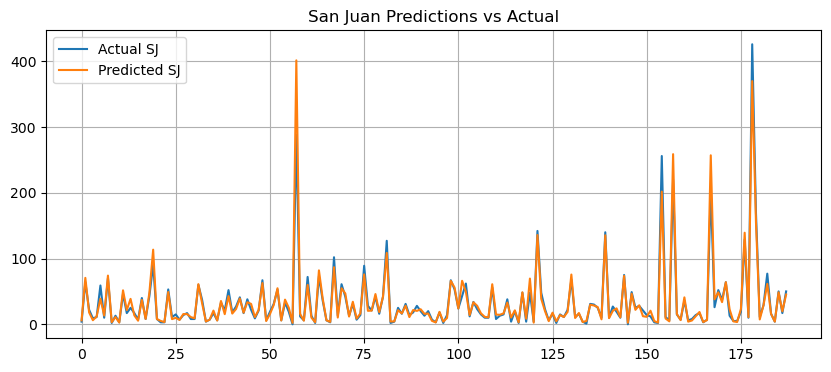

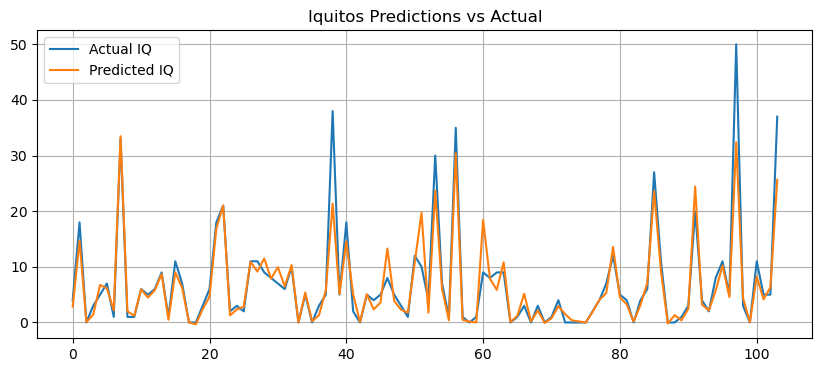

In [7]:
plt.figure(figsize=(10, 4))
plt.plot(y_sj_val.values, label="Actual SJ")
plt.plot(pred_sj, label="Predicted SJ")
plt.legend()
plt.title("San Juan Predictions vs Actual")
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(y_iq_val.values, label="Actual IQ")
plt.plot(pred_iq, label="Predicted IQ")
plt.legend()
plt.title("Iquitos Predictions vs Actual")
plt.grid()
plt.show()


In [8]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 6],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

xgb = XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    scoring='neg_mean_absolute_error',
    n_iter=25,
    cv=3,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_sj_train, y_sj_train)

print("🎯 Best MAE:", -random_search.best_score_)
print("✅ Best Parameters:", random_search.best_params_)

# Use best model
best_model_sj = random_search.best_estimator_


Fitting 3 folds for each of 25 candidates, totalling 75 fits
🎯 Best MAE: 5.307451331780139
✅ Best Parameters: {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [9]:
pip install shap


   ---------------------------------------- 0.0/545.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/545.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/545.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/545.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/545.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/545.2 kB ? eta -:--:--
   ------------------- -------------------- 262.1/545.2 kB ? eta -:--:--
   ------------------- -------------------- 262.1/545.2 kB ? eta -:--:--
   ------------------- -------------------- 262.1/545.2 kB ? eta -:--:--
   ------------------- -------------------- 262.1/545.2 kB ? eta -:--:--
   ------------------- -------------------- 262.1/545.2 kB ? eta -:--:--
   ------------------- -------------------- 262.1/545.2 kB ? eta -:--:--
   ------------------- -------------------- 262.1/545.2 kB ? eta -:--:--
   ------------------- -------------------- 262.1/545.2 kB ? et

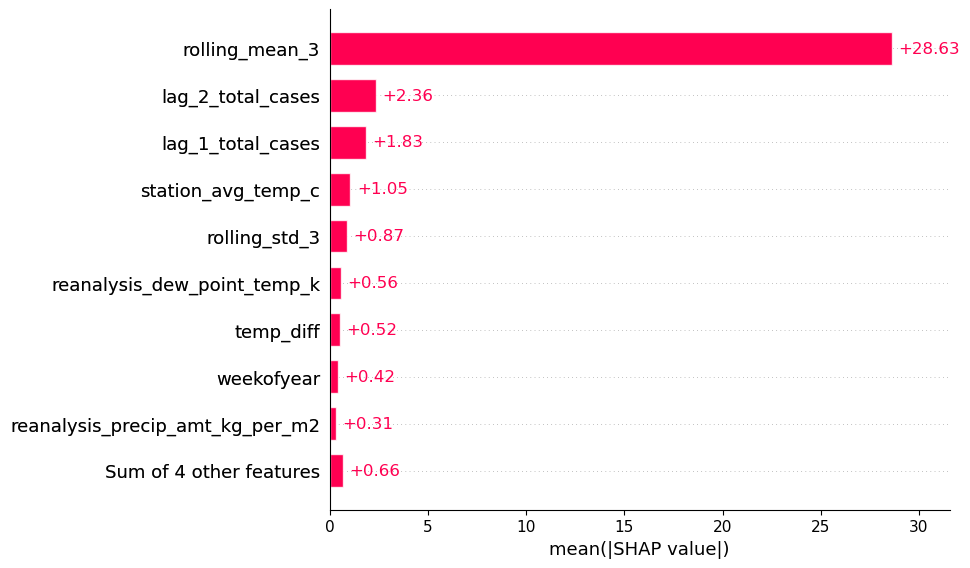

In [10]:
import shap

explainer = shap.Explainer(model_sj, X_sj_train)
shap_values = explainer(X_sj_train)

shap.plots.bar(shap_values)


In [13]:
from xgboost import XGBRegressor

# Define the model first
model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)

# Now fit the model
model.fit(X_sj_train, np.log1p(y_sj_train))  # Training on log-transformed target



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [14]:
pip install lightgbm


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 409.0 kB/s eta 0:00:03
   -------------- ------------------------- 0.5/1.5 MB 409.0 kB/s eta 0:00:03
   -------------- ------------------------- 0.5/1.5 MB 409.0 kB/s eta 0:00:03
   --------------------- ------------------ 0.8/1.5 MB 390.1 kB/s eta 0:00:02
   --------------------- ------------------ 0.8/1.5 MB 390.1 kB/s eta 0:00:02
   --------------------- ------------------ 0.8/1.5 MB 390.1 kB/s eta 0:00:02
   --------------------- ------------------ 0.8/1

In [15]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


In [16]:
# Load data
train_features = pd.read_csv("dengue_features_train.csv")
train_labels = pd.read_csv("dengue_labels_train.csv")
train = train_features.merge(train_labels, on=["city", "year", "weekofyear"])

# Encode city
train["city"] = train["city"].map({"sj": 0, "iq": 1})
train = train.ffill()


In [17]:
# Lag and rolling features
train["lag_1_total_cases"] = train["total_cases"].shift(1)
train["lag_2_total_cases"] = train["total_cases"].shift(2)
train["rolling_mean_3"] = train["total_cases"].rolling(3).mean()
train["rolling_std_3"] = train["total_cases"].rolling(3).std()
train["temp_diff"] = train["reanalysis_max_air_temp_k"] - train["reanalysis_min_air_temp_k"]

# Fill any remaining NaNs
train = train.fillna(0)


In [18]:
# Filter for San Juan
train_sj = train[train["city"] == 0]

# Define feature columns
features = [
    'lag_1_total_cases', 'lag_2_total_cases', 'rolling_mean_3', 'rolling_std_3', 'temp_diff',
    'reanalysis_precip_amt_kg_per_m2', 'station_avg_temp_c', 'station_diur_temp_rng_c',
    'reanalysis_tdtr_k', 'reanalysis_dew_point_temp_k', 'reanalysis_avg_temp_k',
    'reanalysis_relative_humidity_percent', 'weekofyear'
]

X = train_sj[features]
y = train_sj["total_cases"]


In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2173
[LightGBM] [Info] Number of data points in the train set: 748, number of used features: 13
[LightGBM] [Info] Start training from score 34.330214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

LGBMRegressor(learning_rate=0.05, max_depth=4, n_estimators=300,
              random_state=42)

In [21]:
y_pred = model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print("✅ LightGBM MAE:", round(mae, 2))
print("✅ LightGBM RMSE:", round(rmse, 2))


✅ LightGBM MAE: 6.35
✅ LightGBM RMSE: 14.63


In [22]:
import pandas as pd
import numpy as np

# 🔄 Load test data
test = pd.read_csv("dengue_features_test.csv")
test["city_code"] = test["city"].map({"sj": 0, "iq": 1})
test = test.ffill()

# ✅ Reuse exact features used in training
features = [
    'lag_1_total_cases', 'lag_2_total_cases', 'rolling_mean_3', 'rolling_std_3', 'temp_diff',
    'reanalysis_precip_amt_kg_per_m2', 'station_avg_temp_c', 'station_diur_temp_rng_c',
    'reanalysis_tdtr_k', 'reanalysis_dew_point_temp_k', 'reanalysis_avg_temp_k',
    'reanalysis_relative_humidity_percent', 'weekofyear'
]

# 🧠 Feature engineering (same as train)
test["lag_1_total_cases"] = 0  # since we don't know last week's cases in test set
test["lag_2_total_cases"] = 0
test["rolling_mean_3"] = test["reanalysis_avg_temp_k"].rolling(3).mean()
test["rolling_std_3"] = test["reanalysis_avg_temp_k"].rolling(3).std()
test["temp_diff"] = test["reanalysis_max_air_temp_k"] - test["reanalysis_min_air_temp_k"]
test = test.fillna(0)

# 🔀 Split by city
test_sj = test[test["city_code"] == 0].copy()
test_iq = test[test["city_code"] == 1].copy()

# 🎯 Predict with trained XGBoost models
pred_sj = model_sj.predict(test_sj[features])
pred_iq = model_iq.predict(test_iq[features])

# ✅ Round and clip predictions
test_sj["total_cases"] = np.round(pred_sj).astype(int).clip(min=0)
test_iq["total_cases"] = np.round(pred_iq).astype(int).clip(min=0)

# 🔗 Combine and format output
final_pred = pd.concat([test_sj, test_iq])
final_pred = final_pred.sort_values(by=["city", "year", "weekofyear"])
final_pred = final_pred[["city", "year", "weekofyear", "total_cases"]]

# 💾 Save to CSV
final_pred.to_csv("dengue_predictions.csv", index=False)
print("✅ Saved to 'dengue_predictions.csv'")


✅ Saved to 'dengue_predictions.csv'
